## Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv
import zipfile
from google.colab import drive

In [ ]:
import torch

!pip install -q torchinfo
from torchinfo import summary

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split

device= "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(device)

2.0.1+cu118
cuda


## Load Data

In [ ]:
drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/3rd_year_project/data_3000.zip", 'r')
zip_ref.extractall("./data_3000/")
zip_ref.close()

Mounted at /content/drive/


In [ ]:
src = './data_3000/'

# func to read and plot img
def img_read_plot(src, file):
  img = cv.imread(src+file, cv.COLOR_BGR2GRAY)
  plt.imshow(img)
  plt.xtichs([])
  plt.yticks([])
  plt.show()
  return img

# func to read img
def img_read(src, file):
  img = cv.imread(src+file, cv.COLOR_BGR2GRAY)
  return img

files = os.listdir(src)

X, Y = [], []
for file in files:
  X.append(img_read(src,file)/255.) # normalized image
  Y.append(float(file[:-4])) # file name

# split to train and test dataset
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1, shuffle=True)
x_train = np.array(x_train)
x_test = np.array(x_test)
print(x_train.shape, x_test.shape)

x_train_re = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))).astype('float32')
x_test_re = x_test.reshape((len(x_test), np.prod(x_test.shape[1:]))).astype('float32')
print(x_train_re.shape, x_test_re.shape)

(2400, 56, 56) (600, 56, 56)
(2400, 3136) (600, 3136)


In [ ]:
# convert numpy to tensor
x_train_cuda = torch.from_numpy(x_train_re).to(device)
x_test_cuda = torch.from_numpy(x_test_re).to(device)

# create dataset
train_dataset = torch.utils.data.TensorDataset(x_train_cuda)
test_dataset = torch.utils.data.TensorDataset(x_test_cuda)

# create dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, 32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, 32, shuffle=True)

## Build VAE Model

In [ ]:
# network parameters
input_shape = np.shape(x_train_re[0])[0]
original_dim = input_shape
intermediate_dim = 512
latent_dim = 2

In [ ]:
# Encoder
class Encoder(torch.nn.Module):
  def __init__(self, input_shape, intermediate_dim, latent_dim):
    super().__init__()
    self.encoder = torch.nn.Sequential(
        torch.nn.Linear(in_features=input_shape,
                        out_features=intermediate_dim),
        torch.nn.ReLU()
    )

    # mean and sigma layer
    self.z_mean = torch.nn.Linear(in_features=intermediate_dim,
                                  out_features=latent_dim)
    self.z_log_var = torch.nn.Linear(in_features=intermediate_dim,
                                     out_features=latent_dim)

  def reparameterization(self, z_mean, z_log_var):
    epsilon = torch.normal(mean=0, std=1.0, size=(z_mean.shape[0], z_mean.shape[1])).to(device)

    return z_mean + torch.exp(0.5 * z_log_var) * epsilon

  def forward(self, x):
    x = self.encoder(x)
    z_mean = self.z_mean(x)
    z_log_var = self.z_log_var(x)
    z = self.reparameterization(z_mean, z_log_var)

    return z, z_mean, z_log_var

In [ ]:
# Decoder
class Decoder(torch.nn.Module):
  def __init__(self, original_dim, intermediate_dim, latent_dim):
    super().__init__()
    self.decoder_hidden = torch.nn.Sequential(
        torch.nn.Linear(in_features=latent_dim,
                        out_features=intermediate_dim),
        torch.nn.ReLU()
    )
    self.outputs = torch.nn.Sequential(
        torch.nn.Linear(in_features=intermediate_dim,
                     out_features=original_dim),
        torch.nn.Sigmoid()
    )

  def forward(self, x):
    return self.outputs(self.decoder_hidden(x))

In [ ]:
# VAE
class VAE(torch.nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder =decoder

  def forward(self, x):
    z, z_mean, z_log_var = self.encoder(x)
    return self.decoder(z), z_mean, z_log_var

In [ ]:
encoder = Encoder(input_shape, intermediate_dim, latent_dim).to(device)
encoder

Encoder(
  (encoder): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
  )
  (z_mean): Linear(in_features=512, out_features=2, bias=True)
  (z_log_var): Linear(in_features=512, out_features=2, bias=True)
)

In [ ]:
summary(model=encoder,
        input_size=(2400, 3136),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Encoder (Encoder)                        [2400, 3136]         [2400, 2]            --                   True
├─Sequential (encoder)                   [2400, 3136]         [2400, 512]          --                   True
│    └─Linear (0)                        [2400, 3136]         [2400, 512]          1,606,144            True
│    └─ReLU (1)                          [2400, 512]          [2400, 512]          --                   --
├─Linear (z_mean)                        [2400, 512]          [2400, 2]            1,026                True
├─Linear (z_log_var)                     [2400, 512]          [2400, 2]            1,026                True
Total params: 1,608,196
Trainable params: 1,608,196
Non-trainable params: 0
Total mult-adds (G): 3.86
Input size (MB): 30.11
Forward/backward pass size (MB): 9.91
Params size (MB): 6.43
Estimated Total Size (MB): 46.45

In [ ]:
decoder = Decoder(original_dim, intermediate_dim, latent_dim).to(device)
decoder

Decoder(
  (decoder_hidden): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): ReLU()
  )
  (outputs): Sequential(
    (0): Linear(in_features=512, out_features=3136, bias=True)
    (1): Sigmoid()
  )
)

In [ ]:
summary(model=decoder,
        input_size=(2400, 2),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Decoder (Decoder)                        [2400, 2]            [2400, 3136]         --                   True
├─Sequential (decoder_hidden)            [2400, 2]            [2400, 512]          --                   True
│    └─Linear (0)                        [2400, 2]            [2400, 512]          1,536                True
│    └─ReLU (1)                          [2400, 512]          [2400, 512]          --                   --
├─Sequential (outputs)                   [2400, 512]          [2400, 3136]         --                   True
│    └─Linear (0)                        [2400, 512]          [2400, 3136]         1,608,768            True
│    └─Sigmoid (1)                       [2400, 3136]         [2400, 3136]         --                   --
Total params: 1,610,304
Trainable params: 1,610,304
Non-trainable params: 0
Total mult-adds (G): 3.86
Input size (MB): 0.02
For

In [ ]:
vae = VAE(encoder, decoder).to(device)
vae

VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=3136, out_features=512, bias=True)
      (1): ReLU()
    )
    (z_mean): Linear(in_features=512, out_features=2, bias=True)
    (z_log_var): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (decoder_hidden): Sequential(
      (0): Linear(in_features=2, out_features=512, bias=True)
      (1): ReLU()
    )
    (outputs): Sequential(
      (0): Linear(in_features=512, out_features=3136, bias=True)
      (1): Sigmoid()
    )
  )
)

In [ ]:
summary(model=vae,
        input_size=(2400, 3136),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VAE (VAE)                                [2400, 3136]         [2400, 3136]         --                   True
├─Encoder (encoder)                      [2400, 3136]         [2400, 2]            --                   True
│    └─Sequential (encoder)              [2400, 3136]         [2400, 512]          --                   True
│    │    └─Linear (0)                   [2400, 3136]         [2400, 512]          1,606,144            True
│    │    └─ReLU (1)                     [2400, 512]          [2400, 512]          --                   --
│    └─Linear (z_mean)                   [2400, 512]          [2400, 2]            1,026                True
│    └─Linear (z_log_var)                [2400, 512]          [2400, 2]            1,026                True
├─Decoder (decoder)                      [2400, 2]            [2400, 3136]         --                   True
│    └─Sequentia

## Define Loss Function and Optimizer

In [ ]:
# Hyperparameters
epochs = 100
batch_size = 20
learning_rate = 1e-3

In [ ]:
# Loss Function
def vae_loss(x, recon_x, mean, log_var):
  # 1. Reconstrut loss : Cross-entropy
  reconstruction_loss = torch.nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')

  # 2. KL divergence(Latent_loss)
  KLD = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

  return reconstruction_loss + KLD

# Optimizer
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate)

## Train VAE

In [ ]:
torch.manual_seed(42)

for epoch in tqdm(range(epochs)):
  # Train
  vae.train()

  train_loss = 0
  for batch, X in enumerate(train_dataloader):
    X = X[0].to(device)

    recon_x, mean, log_var = vae(X)

    loss = vae_loss(X, recon_x, mean, log_var)

    optimizer.zero_grad()

    train_loss += loss.item()

    loss.backward()

    optimizer.step()

  train_loss = train_loss/len(train_dataloader)

  # Test
  vae.eval()

  test_loss = 0

  with torch.inference_mode():
    for batch, X in enumerate(test_dataloader):
      X = X[0].to(device)

      recon_x, mean, log_var = vae(X)

      loss = vae_loss(X, recon_x, mean, log_var)

      test_loss += loss.item()

  test_loss = test_loss / len(test_dataloader)

  print(f"Epoch {epoch+1}: train loss:{train_loss:.4f} | test loss:{test_loss:.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: train loss:46005.1637 | test loss:41613.1934
Epoch 2: train loss:41641.9149 | test loss:40664.7957
Epoch 3: train loss:40873.2115 | test loss:40075.4426
Epoch 4: train loss:40294.8767 | test loss:39455.8887
Epoch 5: train loss:39982.2058 | test loss:39150.2451
Epoch 6: train loss:39734.5954 | test loss:39123.6530
Epoch 7: train loss:39587.0906 | test loss:39015.3505
Epoch 8: train loss:39426.8473 | test loss:38830.9514
Epoch 9: train loss:39344.5747 | test loss:38868.1925
Epoch 10: train loss:39264.0943 | test loss:38768.8037
Epoch 11: train loss:39156.1096 | test loss:38777.3655
Epoch 12: train loss:39103.5893 | test loss:38641.3723
Epoch 13: train loss:39007.8942 | test loss:38621.6224
Epoch 14: train loss:39028.4642 | test loss:38675.8366
Epoch 15: train loss:38981.7178 | test loss:38605.9769
Epoch 16: train loss:38809.1498 | test loss:38647.1251
Epoch 17: train loss:38843.8945 | test loss:38504.3118
Epoch 18: train loss:38780.3741 | test loss:38542.6199
Epoch 19: train los

## Compare Test and Original Image

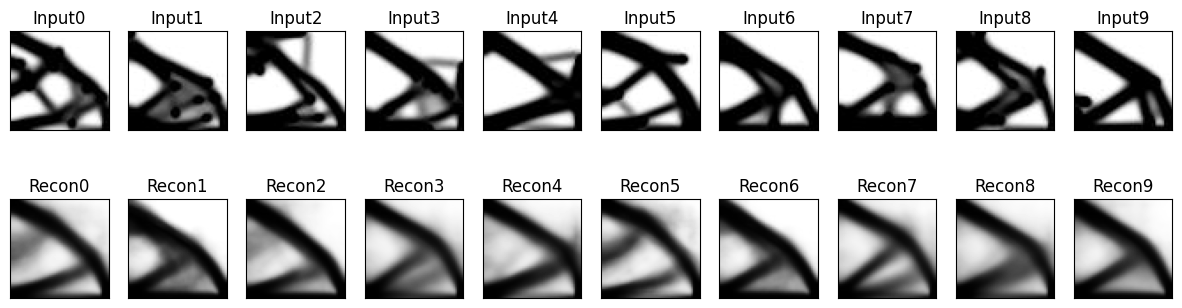

In [ ]:
recon_x_test = vae(x_test_cuda)

n = 10  # how many digits we will display
plt.figure(figsize=(15, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(56,56), vmin=0, vmax=1, cmap="gray")
    plt.title("Input"+str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.colorbar()

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_x_test[0][i].cpu().detach().numpy().reshape(56, 56),vmin=0, vmax=1, cmap="gray")
    plt.title("Recon"+str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.colorbar()
plt.show()